## 5. Add Statistics CSV to Shapefile

Use this notebook to add hydrologic statistic attributes to the segments shapefile. Run this after adding HUC8 outlet attributes to the shapefile.

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import itertools

In [3]:
with open('shp_stats_lookup.json', "r") as f:
    vars = json.load(f)
vars

{'ma12': {'var_description': 'Mean January flow',
  'stats': ['ma12_min_d', 'ma12_avg_d', 'ma12_max_d'],
  'aggregation': ['minimum', 'mean', 'maximum'],
  'stat_descriptions': ['difference between minimum of ensemble ma12 values and Maurer historical',
   'difference between mean of ensemble ma12 values and Maurer historical',
   'difference between maximum of ensemble ma12 values and Maurer historical'],
  'units': 'cfs',
  'difference': 'percentage'},
 'ma13': {'var_description': 'Mean February flow',
  'stats': ['ma13_min_d', 'ma13_avg_d', 'ma13_max_d'],
  'aggregation': ['minimum', 'mean', 'maximum'],
  'stat_descriptions': ['difference between minimum of ensemble ma13 values and Maurer historical',
   'difference between mean of ensemble ma13 values and Maurer historical',
   'difference between maximum of ensemble ma13 values and Maurer historical'],
  'units': 'cfs',
  'difference': 'percentage'},
 'ma14': {'var_description': 'Mean March flow',
  'stats': ['ma14_min_d', 'ma14_a

### Open files and merge

In [4]:
csv = pd.read_csv("stats_diff.csv")
gdf = gpd.read_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/xwalk/seg_h8_outlets.shp")
gdf_stats = pd.merge(gdf, csv, left_on='seg_id_nat', right_on='stream_id', how='left').drop(columns=['stream_id'])

### Visualize

Pick a few variables and plot them.

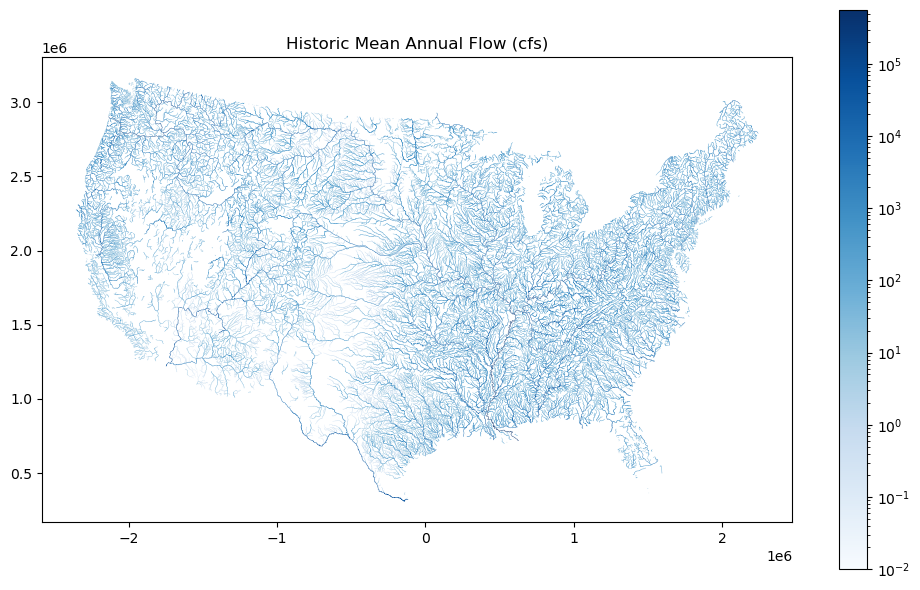

In [5]:
# historic mean annual flow - we plan to use this as the default statistic in the web app map
# use a logarithmic color scale to better show variation

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf_stats.plot(column="ma99_hist", ax=ax, cmap='Blues', norm=colors.LogNorm(), legend=True, linewidth=0.3)
plt.title("Historic Mean Annual Flow (cfs)")
plt.tight_layout()

In [6]:
def diff_plot(stat, desc, units, method):

    if "avg" in stat:

        print("plotting",stat,desc,units,method)

        if method == 'percentage':
            divnorm = colors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)

        if method == 'absolute':
            vmin = gdf_stats[stat].min()
            vmax = gdf_stats[stat].max()
            if abs(vmin) > abs(vmax):
                divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=-vmin)
            else:
                divnorm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

        fig_, ax = plt.subplots(1, 1, figsize=(10, 6))
        gdf_stats.plot(ax=ax, color='lightgray', linewidth=0.3, zorder=0)
        gdf_stats.plot(column=stat, ax=ax, cmap='BrBG', norm=divnorm, legend=True, linewidth=0.3, zorder=1)
        plt.title(f"Change in {desc} ({units}): {method}")
        plt.show()
    
    else:
        print("skipping", stat)

skipping ma12_min_d
plotting ma12_avg_d Mean January flow cfs percentage


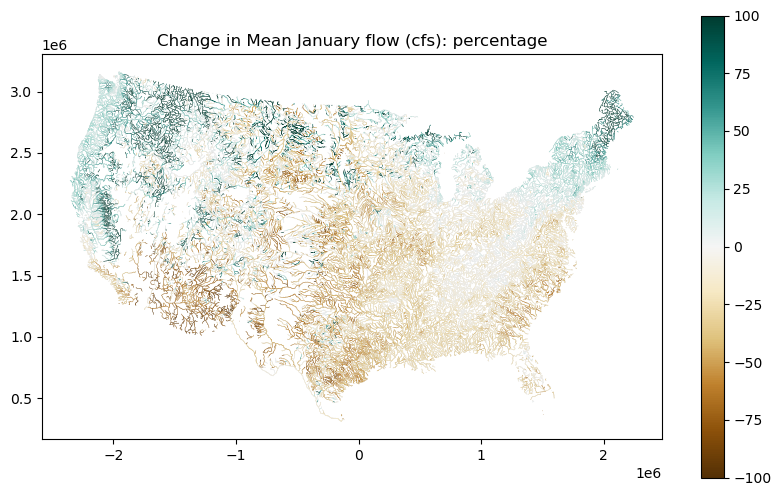

skipping ma12_max_d
skipping ma13_min_d
plotting ma13_avg_d Mean February flow cfs percentage


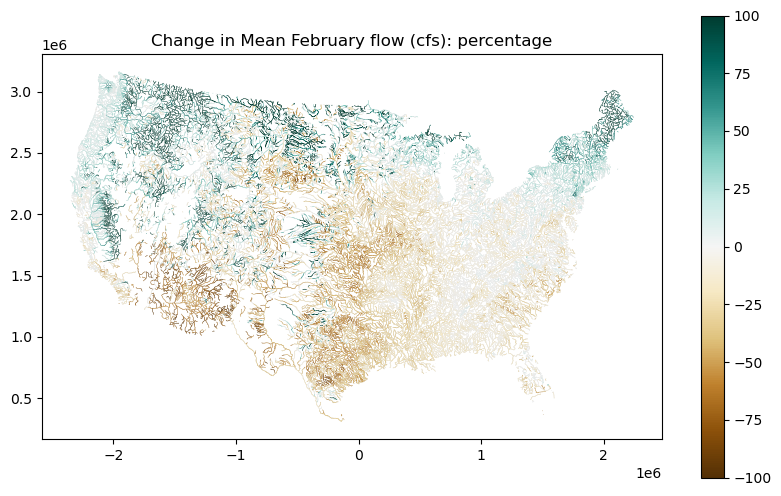

skipping ma13_max_d
skipping ma14_min_d
plotting ma14_avg_d Mean March flow cfs percentage


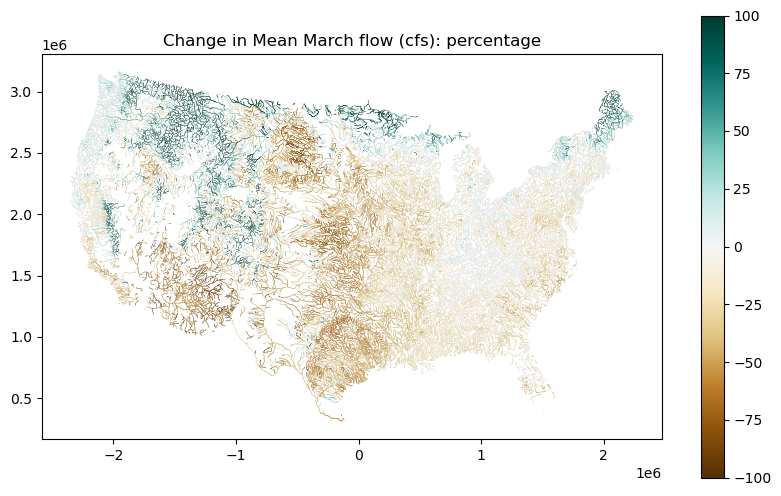

skipping ma14_max_d
skipping ma15_min_d
plotting ma15_avg_d Mean April flow cfs percentage


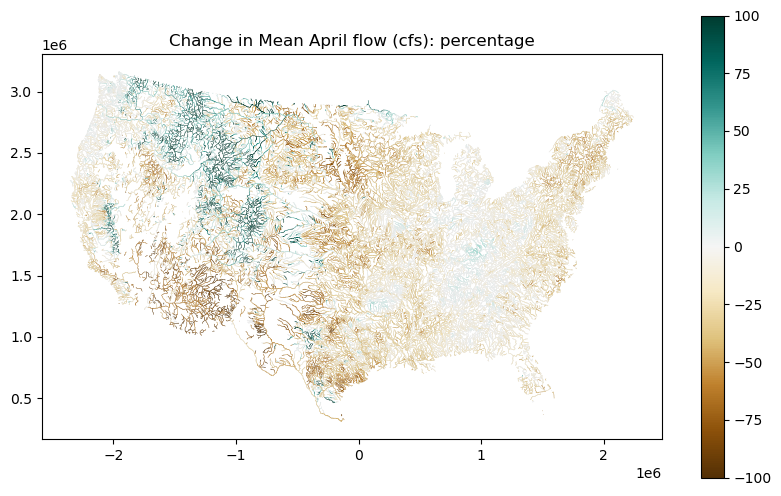

skipping ma15_max_d
skipping ma16_min_d
plotting ma16_avg_d Mean May flow cfs percentage


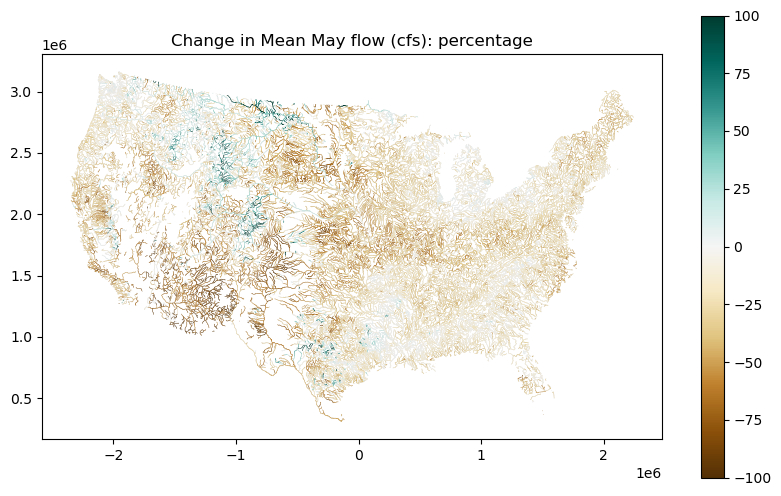

skipping ma16_max_d
skipping ma17_min_d
plotting ma17_avg_d Mean June flow cfs percentage


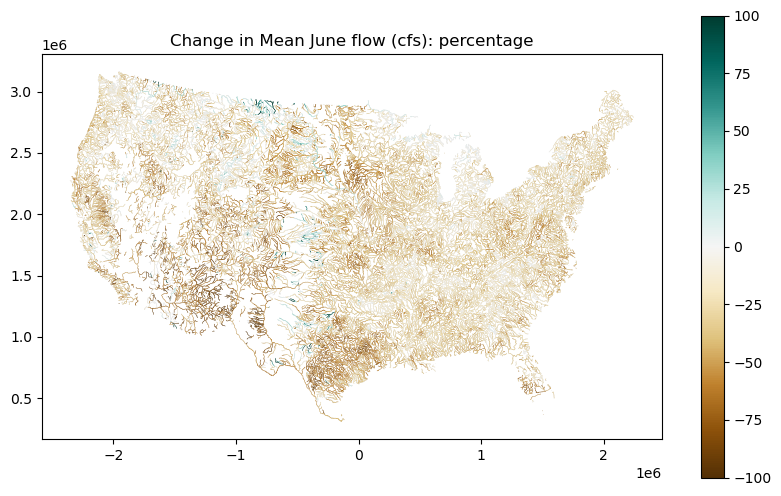

skipping ma17_max_d
skipping ma18_min_d
plotting ma18_avg_d Mean July flow cfs percentage


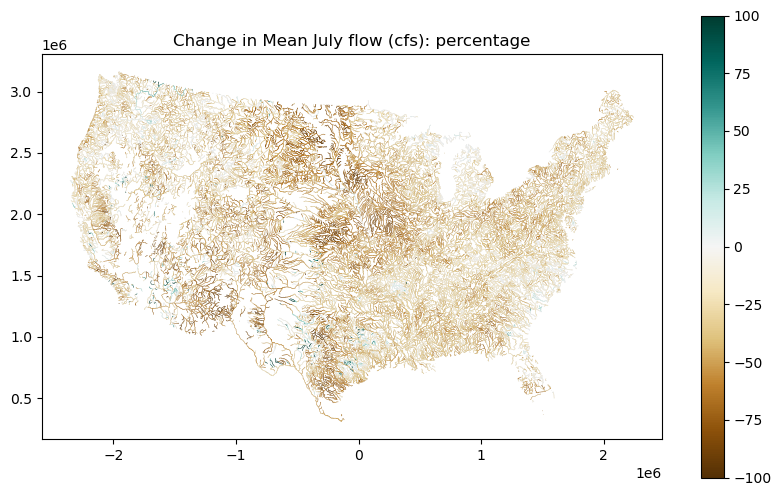

skipping ma18_max_d
skipping ma19_min_d
plotting ma19_avg_d Mean August flow cfs percentage


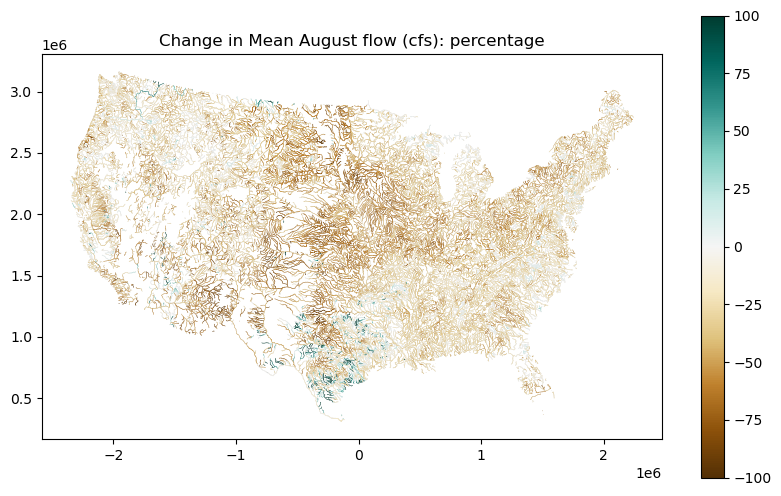

skipping ma19_max_d
skipping ma20_min_d
plotting ma20_avg_d Mean September flow cfs percentage


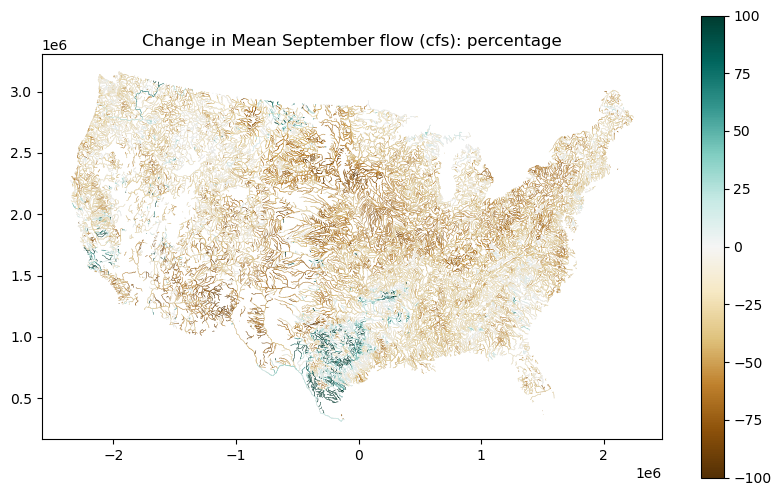

skipping ma20_max_d
skipping ma21_min_d
plotting ma21_avg_d Mean October flow cfs percentage


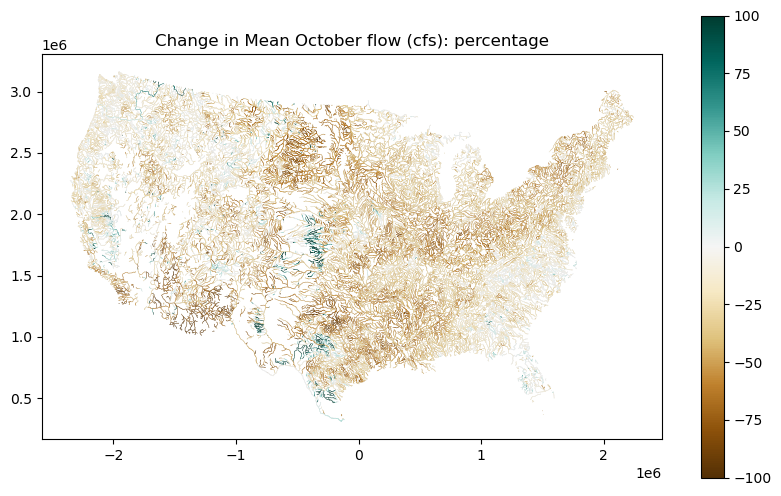

skipping ma21_max_d
skipping ma22_min_d
plotting ma22_avg_d Mean November flow cfs percentage


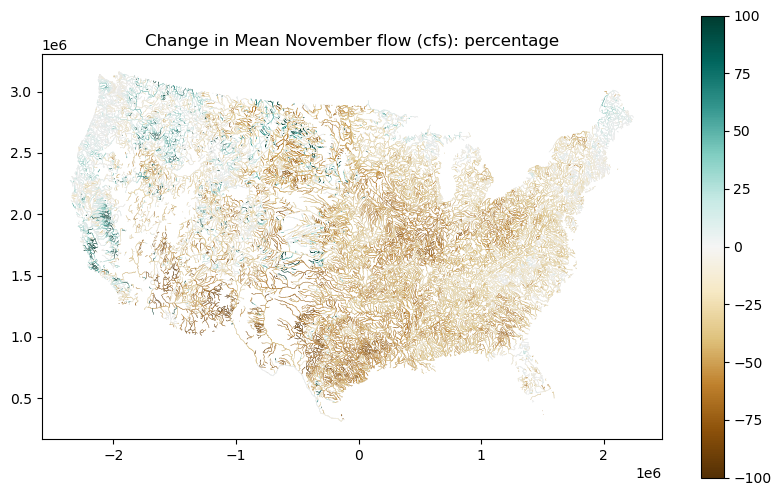

skipping ma22_max_d
skipping ma23_min_d
plotting ma23_avg_d Mean December flow cfs percentage


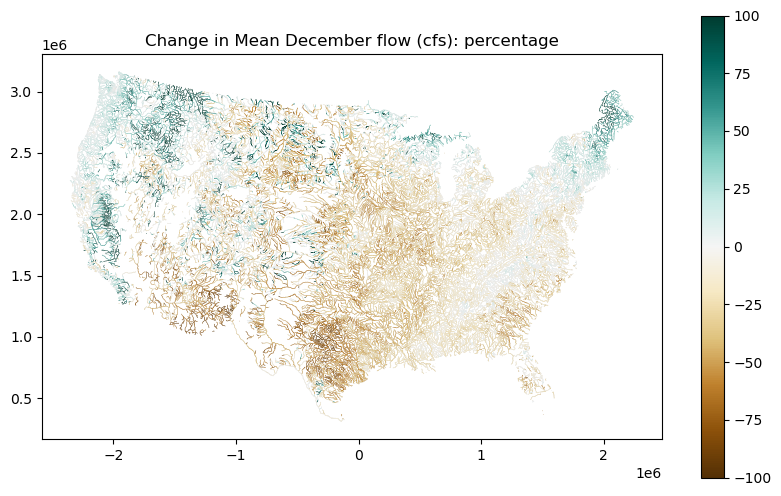

skipping ma23_max_d
skipping dh1_min_d
skipping dh1_max_d
skipping dl1_min_d
skipping dl1_max_d
skipping dh15_min_d
plotting dh15_avg_d High Flow Pulse Duration days per year absolute


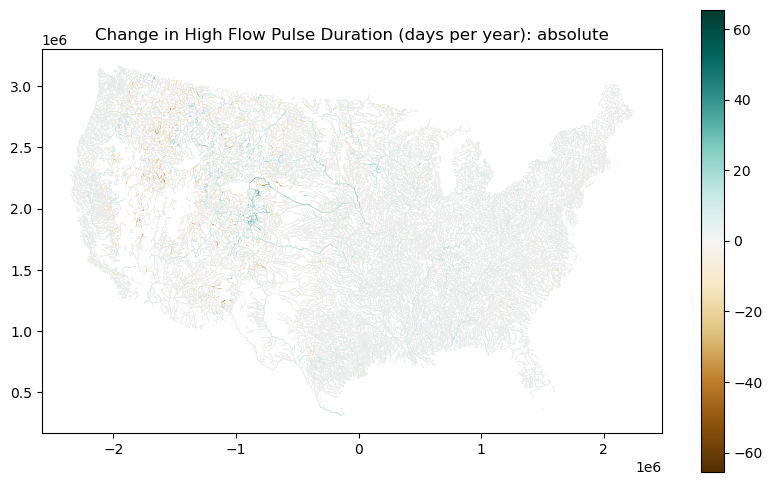

skipping dh15_max_d
skipping dl16_min_d
plotting dl16_avg_d Low Flow Pulse Duration days per year absolute


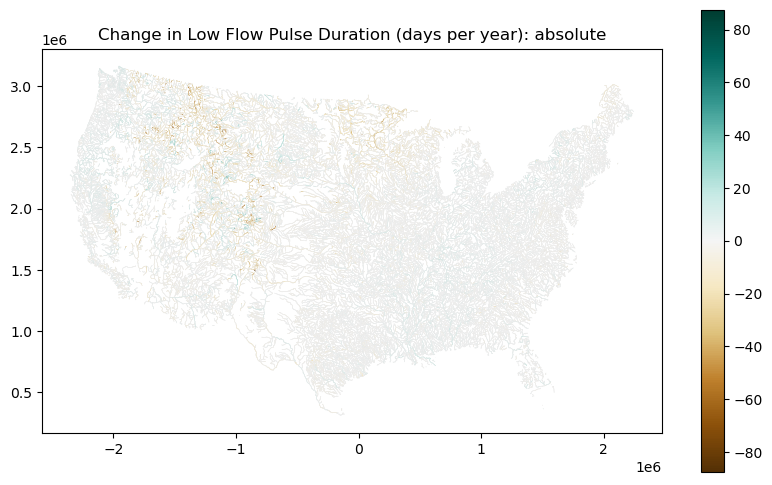

skipping dl16_max_d
skipping fh1_min_d
plotting fh1_avg_d High Flood Pulse Count events per year absolute


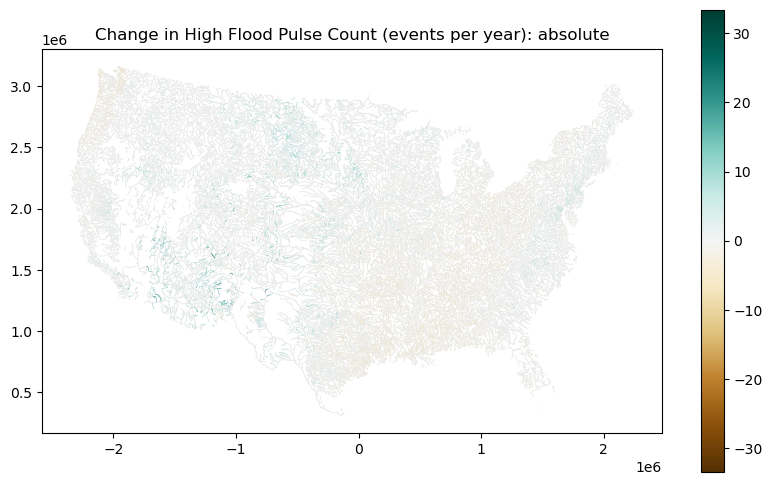

skipping fh1_max_d
skipping fl1_min_d
plotting fl1_avg_d Low Flood Pulse Count events per year absolute


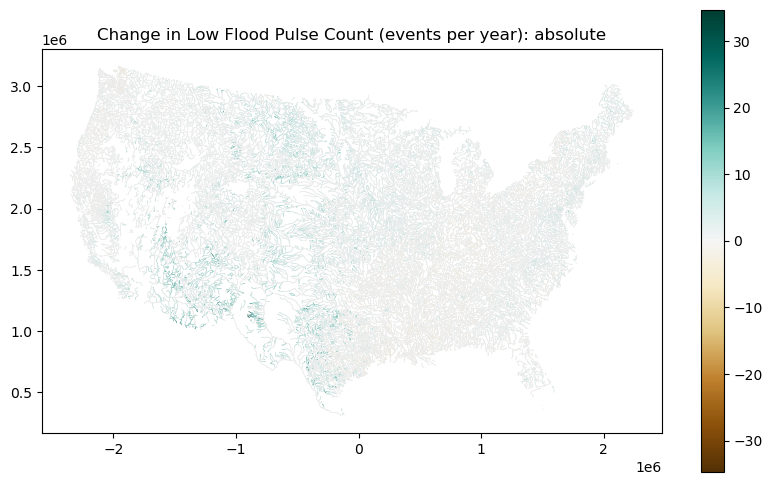

skipping fl1_max_d
skipping th1_min_d
plotting th1_avg_d Julian Date of Annual Maximum day of year absolute


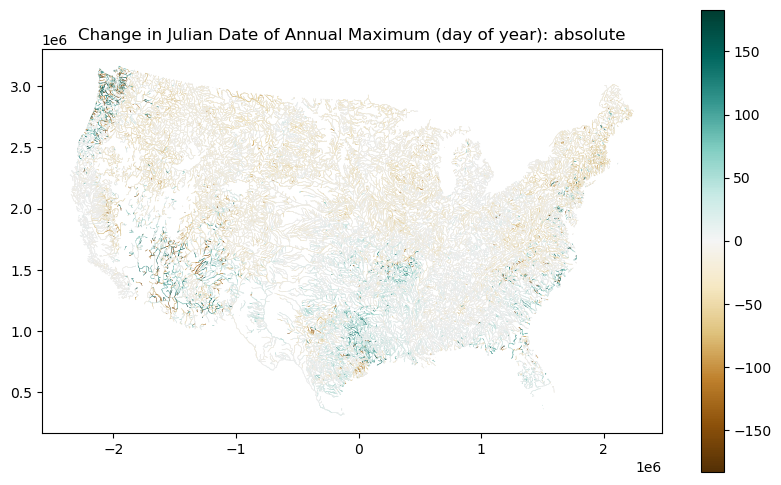

skipping th1_max_d
skipping tl1_min_d
plotting tl1_avg_d Julian Date of Annual Minimum day of year absolute


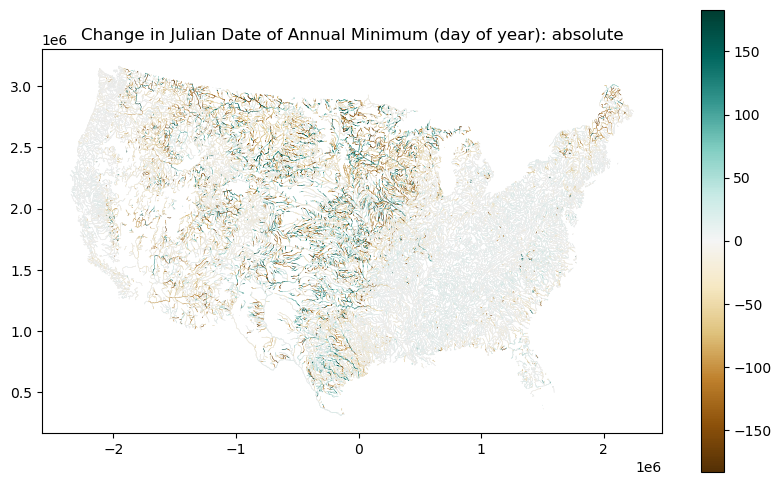

skipping tl1_max_d
skipping ma99_min_d
plotting ma99_avg_d Mean annual flow cfs percentage


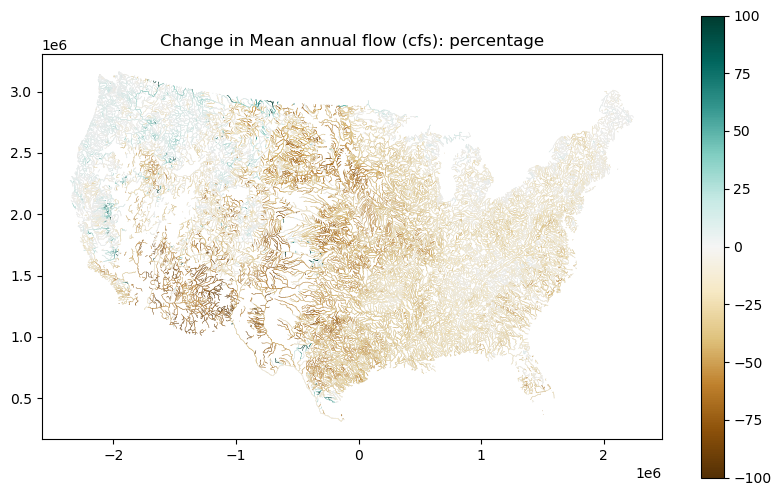

skipping ma99_max_d


In [7]:
for var in vars.keys():
    v = vars[var]
    for stat, desc, units, method in zip(v['stats'], itertools.cycle([v['var_description']]), itertools.cycle([v['units']]), itertools.cycle([v['difference']])):
        diff_plot(stat, desc, units, method)

### Drop
Drop the `th1` and `tl1` columns and save. Drop rows where all stats are NaN.

In [8]:
cols_to_drop = [c for c in gdf_stats.columns if "th1" in c or "tl1" in c]
cols_to_drop

['th1_min_d', 'th1_avg_d', 'th1_max_d', 'tl1_min_d', 'tl1_avg_d', 'tl1_max_d']

In [9]:
# find all rows where stat values are NaN
# first list all stats from the vars dict
all_stats = []
for var in vars.keys():
    v = vars[var]
    all_stats.extend(v['stats'])

nan_rows = gdf_stats[all_stats].isna().any(axis=1)
nan_rows.sum()


284

In [11]:
# drop ununsed cols
gdf_stats.drop(columns=cols_to_drop, inplace=True)

# drop nan rows
gdf_stats_to_save = gdf_stats[~nan_rows]

### Save

In [12]:
gdf_stats_to_save.to_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/xwalk/seg_h8_outlet_stats.shp")